# Using Neo4j LlamaIndex query engine with AG2 agents for GraphRAG Question & Answering

 AG2 provides GraphRAG integration using agent capabilities. This is an example to integrate Neo4j  property graph and LlamaIndex graph query engine.


### info Requirements
llama-index dependencies, which is required to use Neo4j prpoerty graph

`pip install llama-index==0.12.5 llama-index-graph-stores-neo4j==0.4.2 llama-index-core==0.12.5`



## Set Configuration and OpenAI API Key

By default, in order to use LlamaIndex with Neo4j you need to have an OpenAI key in your environment variable `OPENAI_API_KEY`.

You can utilise an OAI_CONFIG_LIST file and extract the OpenAI API key and put it in the environment, as will be shown in the following cell.

Alternatively, you can load the environment variable yourself.

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

In [14]:
import os

import autogen

config_list = autogen.config_list_from_json(env_or_file="OAI_CONFIG_LIST", file_location="../")

# Put the OpenAI API key into the environment
os.environ["OPENAI_API_KEY"] = config_list[0]["api_key"]

In [15]:
# This is needed to allow nested asyncio calls for Neo4j in Jupyter
import nest_asyncio

nest_asyncio.apply()

## Key Information: Using Neo4j with LLM Models 🚀

> **Important**  
> - **Default Models**:
>   - **Question Answering**: OpenAI's `GPT-4o` with `temperature=0.0`.
>   - **Embedding**: OpenAI's `text-embedding-3-small`.
> 
> - **Customization**:
>   You can change these defaults by setting the following parameters on the `Neo4jGraphQueryEngine`:
>   - `llm`: Specify a LLM instance with a llm you like.
>   - `embedding`: Specify a BaseEmbedding instance with a embedding model.
> - **Reference**
>   - https://docs.llamaindex.ai/en/stable/module_guides/models/llms/
>   - https://docs.llamaindex.ai/en/stable/examples/property_graph/graph_store/


## Create a Knowledge Graph with Your Own Data

**Note:** You need to have a Neo4j database running. If you are running one in a Docker container, please ensure your Docker network is setup to allow access to it. 

In this example, the Neo4j endpoint is set to host="bolt://172.17.0.3" and port=7687, please adjust accordingly. For how to spin up a Neo4j with Docker, you can refer to [this](https://docs.llamaindex.ai/en/stable/examples/property_graph/property_graph_neo4j/#:~:text=stores%2Dneo4j-,Docker%20Setup,%C2%B6,-To%20launch%20Neo4j)

We initialise the database with a Word document, creating the Property graph in Neo4j.

### A Simple Example

In this example, the graph schema is auto-generated. This allows you to load data without specifying the specific types of entities and relationships that will make up the database. However, it will only use some default simple relationships including "WORKED_ON", "MENTIONS", "LOCATED_IN" 

LlamaIndex supports a lot of extensions including docx, text, pdf, csv, etc. Find more details in Neo4jGraphQueryEngine. You may need to install dependencies for each extension. In this example, we need `pip install docx2txt`

We start by creating a Neo4j property graph (knowledge graph) with a sample employee handbook of a finctional company called BUZZ

In [ ]:
# load documents
from autogen.agentchat.contrib.graph_rag.document import Document, DocumentType

input_path = "../test/agentchat/contrib/graph_rag/BUZZ_Employee_Handbook.docx"
input_documents = [Document(doctype=DocumentType.TEXT, path_or_url=input_path)]

In [ ]:
# pip install docx2txt
# Auto generate graph schema from unstructured data
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI

from autogen import ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.graph_rag.neo4j_graph_query_engine import Neo4jGraphQueryEngine

# Create Neo4jGraphQueryEngine
query_engine = Neo4jGraphQueryEngine(
    username="neo4j",  # Change if you reset username
    password="password",  # Change if you reset password
    host="bolt://172.17.0.3",  # Change
    port=7687,  # if needed
    llm=OpenAI(model="gpt-4o", temperature=0.0),  # Default, no need to specify
    embedding=OpenAIEmbedding(model_name="text-embedding-3-small"),  # except you want to use a different model
    database="neo4j",  # Change if you want to store the graphh in your custom database
)

# Ingest data and initialize the database
query_engine.init_db(input_doc=input_documents)

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


The Property graph screenshot is shown below:

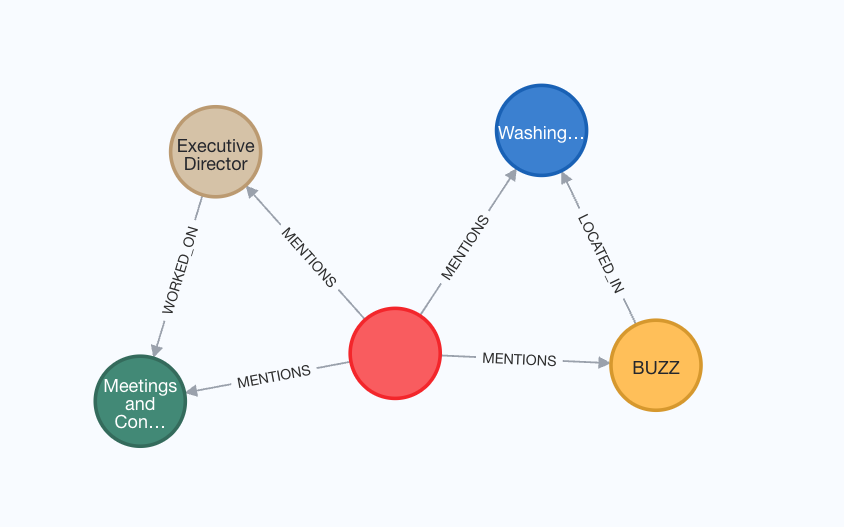

### Add capability to a ConversableAgent and query them
Please be aware that currently query engine doesn't have a conversation history itself (TODO)

In [21]:
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Create a ConversableAgent (no LLM configuration)
graph_rag_agent = ConversableAgent(
    name="paul_graham_agent",
    human_input_mode="NEVER",
)

# Associate the capability with the agent
graph_rag_capability = Neo4jGraphCapability(query_engine)
graph_rag_capability.add_to_agent(graph_rag_agent)

# Create a user proxy agent to converse with our RAG agent
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="ALWAYS",
)

user_proxy.initiate_chat(graph_rag_agent, message="Which company is the employer?")

user_proxy (to paul_graham_agent):

Which company is the employer?



--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

BUZZ

--------------------------------------------------------------------------------
user_proxy (to paul_graham_agent):

What policies does BUZZ have?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

BUZZ has policies related to severe weather conditions, liberal leave, reimbursement of expenses, separation including resignation, termination or lay-off, and discharge criteria.

--------------------------------------------------------------------------------
user_proxy (to paul_graham_agent):

How is reimbursement of expenses defined?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

Reimbursement of expenses is authorized for reasonable and necessary expenses incurred in carrying out job responsibilities. This includes expenses such 

ChatResult(chat_id=None, chat_history=[{'content': 'Which company is the employer?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'BUZZ', 'role': 'user', 'name': 'paul_graham_agent'}, {'content': 'What policies does BUZZ have?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'BUZZ has policies related to severe weather conditions, liberal leave, reimbursement of expenses, separation including resignation, termination or lay-off, and discharge criteria.', 'role': 'user', 'name': 'paul_graham_agent'}, {'content': 'How is reimbursement of expenses defined?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'Reimbursement of expenses is authorized for reasonable and necessary expenses incurred in carrying out job responsibilities. This includes expenses such as mileage or transportation, parking fees, business telephone calls, and meal costs when required to attend a luncheon or banquet. Employees serving in an official capacity for BUZZ at conferences and meetin

### Revisit the example by defining custom entities, relations and schema

In [ ]:
from typing import Literal

# best practice to use upper-case
entities = Literal["EMPLOYEE", "EMPLOYER", "POLICY", "BENEFIT", "POSITION", "DEPARTMENT", "CONTRACT", "RESPONSIBILITY"]
relations = Literal[
    "FOLLOWS",
    "PROVIDES",
    "APPLIES_TO",
    "DEFINED_AS",
    "ASSIGNED_TO",
    "PART_OF",
    "MANAGES",
    "REQUIRES",
    "ENTITLED_TO",
    "REPORTS_TO",
]

# define which entities can have which relations
validation_schema = {
    "EMPLOYEE": ["FOLLOWS", "APPLIES_TO", "ASSIGNED_TO", "ENTITLED_TO", "REPORTS_TO"],
    "EMPLOYER": ["PROVIDES", "DEFINED_AS", "MANAGES", "REQUIRES"],
    "POLICY": ["APPLIES_TO", "DEFINED_AS", "REQUIRES"],
    "BENEFIT": ["PROVIDES", "ENTITLED_TO"],
    "POSITION": ["DEFINED_AS", "PART_OF", "ASSIGNED_TO"],
    "DEPARTMENT": ["PART_OF", "MANAGES", "REQUIRES"],
    "CONTRACT": ["PROVIDES", "REQUIRES", "APPLIES_TO"],
    "RESPONSIBILITY": ["ASSIGNED_TO", "REQUIRES", "DEFINED_AS"],
}

# Create Neo4jGraphQueryEngine
query_engine = Neo4jGraphQueryEngine(
    username="neo4j",  # Change if you reset username
    password="password",  # Change if you reset password
    host="bolt://172.17.0.3",  # Change
    port=7687,  # if needed
    database="neo4j",  # Change if you want to store the graphh in your custom database
    llm=OpenAI(model="gpt-4o", temperature=0.0),  # Default, no need to specify
    entities=entities,  # possible entities
    relations=relations,  # possible relations
    validation_schema=validation_schema,  # schema to validate the extracted triplets
    strict=True,  # enofrce the extracted triplets to be in the schema
)

# Ingest data and initialize the database
query_engine.init_db(input_doc=input_documents)

Generating embeddings: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


The Property graph screenshot is shown below:

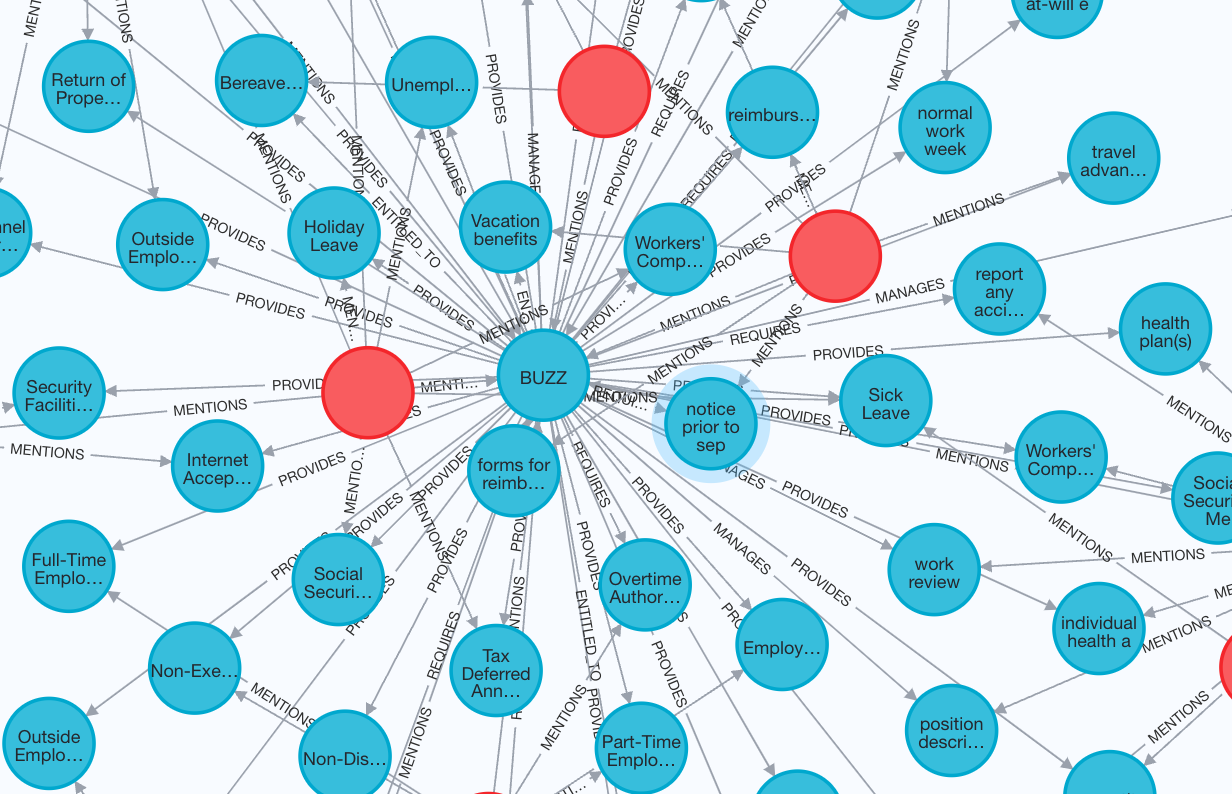

### Add capability to a ConversableAgent and query them again
You should find the answers improve if the schema fits well

In [27]:
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Create a ConversableAgent (no LLM configuration)
graph_rag_agent = ConversableAgent(
    name="paul_graham_agent",
    human_input_mode="NEVER",
)

# Associate the capability with the agent
graph_rag_capability = Neo4jGraphCapability(query_engine)
graph_rag_capability.add_to_agent(graph_rag_agent)

# Create a user proxy agent to converse with our RAG agent
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="ALWAYS",
)

user_proxy.initiate_chat(graph_rag_agent, message="Which company is the employer?")

user_proxy (to paul_graham_agent):

Which company is the employer?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

BUZZ

--------------------------------------------------------------------------------
user_proxy (to paul_graham_agent):

What polices does BUZZ have?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

BUZZ has policies related to employment, computer and information security, internet acceptable use, solicitation, hours of work, attendance, punctuality, and unauthorized access to other organizations' computer systems and data.

--------------------------------------------------------------------------------
user_proxy (to paul_graham_agent):

How is attendance policy defined?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

Employees are expected to meet the performanc

ChatResult(chat_id=None, chat_history=[{'content': 'Which company is the employer?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'BUZZ', 'role': 'user', 'name': 'paul_graham_agent'}, {'content': 'What polices does BUZZ have?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': "BUZZ has policies related to employment, computer and information security, internet acceptable use, solicitation, hours of work, attendance, punctuality, and unauthorized access to other organizations' computer systems and data.", 'role': 'user', 'name': 'paul_graham_agent'}, {'content': 'How is attendance policy defined?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': "Employees are expected to meet the performance standards of their job at BUZZ and will be evaluated based on these standards. They are also required to adhere to BUZZ scheduling demands regardless of any outside work requirements. If outside employment interferes with an employee's job performance or their ability to m

### Incrementally add new documents to the existing knoweldge graph!

In [28]:
input_path = "../test/agentchat/contrib/graph_rag/BUZZ_Equal-Employment-Opportunity-Policy-Detailed.docx"
input_documents = [Document(doctype=DocumentType.TEXT, path_or_url=input_path)]

_ = query_engine.add_records(input_documents)

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Checking the property graph, we'll find a new pocily (entity) called Equal Employment Opportunity Policy is added

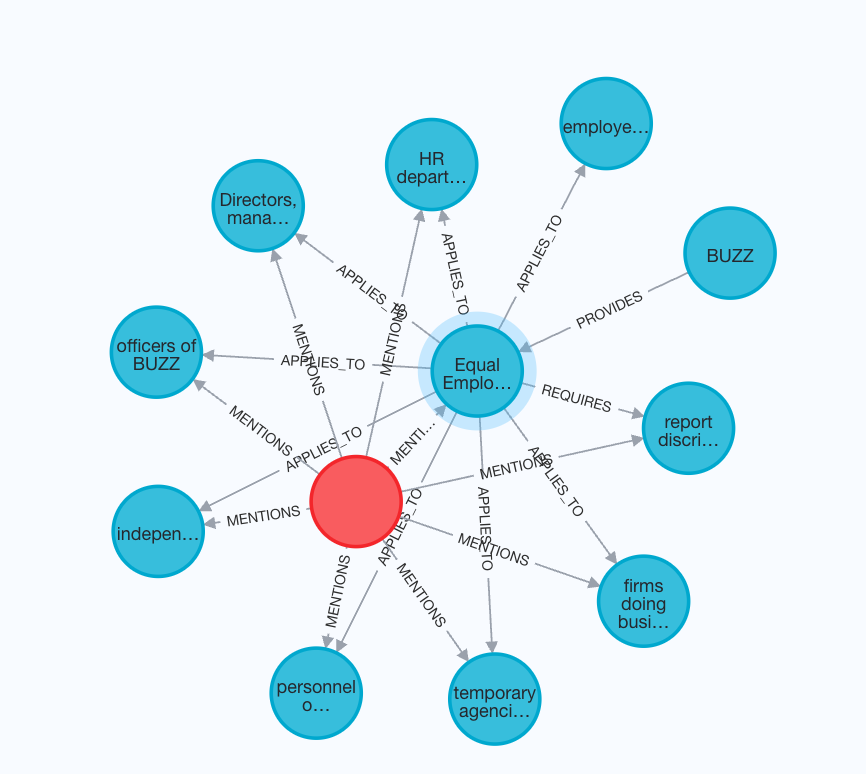

### Now let's create a new GraphRag agent and some questions related to both documents

In [32]:
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Ask questions about both documents
user_proxy.initiate_chat(graph_rag_agent, message="What is Equal Employment Opportunity Policy at BUZZ?")

user_proxy (to paul_graham_agent):

What is Equal Employment Opportunity Policy at BUZZ?

--------------------------------------------------------------------------------
paul_graham_agent (to user_proxy):

Equal Employment Opportunity Policy at BUZZ ensures that discrimination and harassment are prohibited, and it provides equal employment opportunities to all employees and applicants without regard to various characteristics such as race, color, religion, sex, sexual orientation, and more. The policy applies to officers of BUZZ, temporary agencies, employees, firms doing business with BUZZ, personnel working on premises, HR department, Directors, managers, supervisors, and independent contractors. BUZZ conforms to all applicable laws and regulations related to equal employment opportunity.

--------------------------------------------------------------------------------
user_proxy (to paul_graham_agent):

List additional policies execpt Equal Employment Opportunity Policy at BUZZ

--

ChatResult(chat_id=None, chat_history=[{'content': 'What is Equal Employment Opportunity Policy at BUZZ?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'Equal Employment Opportunity Policy at BUZZ ensures that discrimination and harassment are prohibited, and it provides equal employment opportunities to all employees and applicants without regard to various characteristics such as race, color, religion, sex, sexual orientation, and more. The policy applies to officers of BUZZ, temporary agencies, employees, firms doing business with BUZZ, personnel working on premises, HR department, Directors, managers, supervisors, and independent contractors. BUZZ conforms to all applicable laws and regulations related to equal employment opportunity.', 'role': 'user', 'name': 'paul_graham_agent'}, {'content': 'List additional policies execpt Equal Employment Opportunity Policy at BUZZ', 'role': 'assistant', 'name': 'user_proxy'}, {'content': 'Outside Employment Policy, Non-Disclosure of